In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv('salary.csv')

In [3]:
df.head()

,YearsExperience,Salary
0,1.1,39343
1,1.3,46205
2,1.5,37731
3,2.0,43525
4,2.2,39891


In [4]:
#pip install sagemaker

In [4]:
import sagemaker
#boto3 use to interface with services from AWS such as S3 or EC2
import boto3

In [5]:
#create session to put in model later
session= sagemaker.Session()
#to use sage maker locally, need to install CLI in terminal

In [6]:
#Define the S3 bucket and prefix that we want to use in this session
bucket = 'bichinh-practice' #created in AWS
prefix = 'linear_learner' #prefix is subfolder within bucket

In [8]:
#role = sagemaker.get_execution_role()


#This does not work because my local machine does not have IAM role
#I will use the arn of my local machine instead of aws role
#role='arn:aws:iam::715120690714:role/service-role/AmazonSageMaker-ExecutionRole-20210524T215690'
#to find arn in local machine, first create localsm by the code : conda create -n localsm
#second activate localsm : conda activate localsm
#final : aws iam list-roles|grep SageMaker-Execution

In [7]:
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::622104956362:role/service-role/AmazonSageMaker-ExecutionRole-20210529T215386


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X=df[['YearsExperience']]
y=df[['Salary']]

In [11]:
X.head()

,YearsExperience
0,1.1
1,1.3
2,1.5
3,2.0
4,2.2


In [12]:
#the model only supports float32 tensor
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [14]:
X_train.shape

(28, 1)

In [15]:
#Labels must be a Vector
y_train=y_train[:,0]

In [16]:
y_train

array([113812.,  61111.,  63218., 122391.,  66029., 135675., 127345.,
        57189.,  98273.,  83088., 116969.,  39891., 112635., 128765.,
        91738.,  93940., 126756., 121872.,  46205.,  81363.,  37731.,
       139465.,  60150.,  67938.,  54445.,  43525., 101302., 105582.],
      dtype=float32)

In [17]:
#the input support recordIO, and the io module allows for dealing with various type of IO
import io
import sagemaker.amazon.common as smac #sage maker common library

In [18]:
#convert the data in numpy array format to RecordIO format
#This is the format required by SageMaker

buf = io.BytesIO() #create an in-memory byte array
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)

# When you write to in-memory byte arrays, it increments 1 every time you write to it
# Let's reset that back to zero 
buf.seek(0)

0

In [19]:
import os

# Code to upload RecordIO data to S3
 
# Key refers to the name of the file    
key = 'linear-train-data'

# The following code uploads the data in record-io format to S3 bucket to be accessed later for training
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

# Let's print out the training data location in s3
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://bichinh-practice/linear_learner/train/linear-train-data


In [20]:
# Make sure that the target label is a vector
y_test = y_test[:,0]

In [21]:
# Code to upload RecordIO data to S3

buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
smac.write_numpy_to_dense_tensor(buf, X_test, y_test)
buf.seek(0) 
# When you write to in-memory byte arrays, it increments 1 every time you write to it
# Let's reset that back to zero 


0

In [22]:
# Key refers to the name of the file    
key = 'linear-test-data'

# The following code uploads the data in record-io format to S3 bucket to be accessed later for training
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test', key)).upload_fileobj(buf)

# Let's print out the testing data location in s3
s3_test_data = 's3://{}/{}/test/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_test_data))

uploaded training data location: s3://bichinh-practice/linear_learner/test/linear-test-data


In [23]:
# create an output placeholder in S3 bucket to store the linear learner output

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://bichinh-practice/linear_learner/output


In [26]:
# This code is used to get the training container of sagemaker built-in algorithms
# all we have to do is to specify the name of the algorithm, that we want to use

# Let's obtain a reference to the linearLearner container image
# Note that all regression models are named estimators
# You don't have to specify (hardcode) the region, get_image_uri will get the current region name using boto3.Session

from sagemaker.amazon.amazon_estimator import image_uris

container = sagemaker.image_uris.retrieve('linear-learner', boto3.Session().region_name )

In [30]:
# We have pass in the container, the type of instance that we would like to use for training 
# output path and sagemaker session into the Estimator. 
# We can also specify how many instances we would like to use for training
# sagemaker_session = sagemaker.Session()

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.c4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = session)


# We can tune parameters like the number of features that we are passing in, type of predictor like 'regressor' or 'classifier', mini batch size, epochs
# Train 32 different versions of the model and will get the best out of them (built-in parameters optimization!)

linear.set_hyperparameters(feature_dim = 1,
                           predictor_type = 'regressor',
                           mini_batch_size = 5,
                           epochs = 5,
                           num_models = 32,
                           loss = 'absolute_loss')

# Now we are ready to pass in the training data from S3 to train the linear learner model

linear.fit({'train': s3_train_data})

# Let's see the progress using cloudwatch logs

2021-05-30 03:21:07 Starting - Starting the training job...
2021-05-30 03:21:09 Starting - Launching requested ML instancesProfilerReport-1622344867: InProgress
......
2021-05-30 03:22:36 Starting - Preparing the instances for training............
2021-05-30 03:24:36 Downloading - Downloading input data
2021-05-30 03:24:36 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/30/2021 03:24:35 INFO 139871007180608] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bi

In [47]:
# Deploying the model to perform inference 

linear_regressor = linear.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge')

---------------!

In [51]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
linear_regressor.serializer = CSVSerializer()
linear_regressor.deserializers = JSONDeserializer()

In [52]:
result = linear_regressor.predict(X_test)

In [66]:
import json
import matplotlib.pyplot as plt

In [62]:
result=json.loads(result)

In [63]:
# Since the result is in json format, we access the scores by iterating through the scores in the predictions

predictions = np.array([r['score'] for r in result['predictions']])

In [64]:
predictions.shape

(7,)

Text(0.5, 1.0, 'Salary vs. Years of Experience')

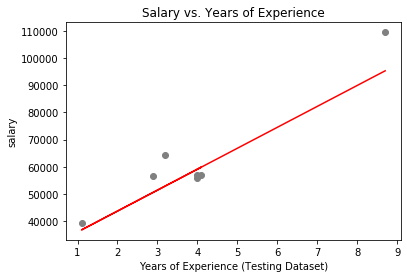

In [67]:
# VISUALIZE TEST SET RESULTS
plt.scatter(X_test, y_test, color = 'gray')
plt.plot(X_test, predictions, color = 'red')
plt.xlabel('Years of Experience (Testing Dataset)')
plt.ylabel('salary')
plt.title('Salary vs. Years of Experience')

In [68]:
# Delete the end-point

linear_regressor.delete_endpoint()